In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('../functions.R')
source('../parameters.sh')
source('parameters.sh')


In [3]:
devtools::load_all(multiSnpnet_src_d)


Loading multiSnpnet



In [4]:
find_argmax_lambda_idx(file.path(RData_d, results_sub_d))


[1] 92

In [5]:
rdata_base


[1] "output_lambda_92"

In [6]:
load(file.path(RData_d, results_sub_d, paste0(rdata_base, '.RData')))


In [7]:
svd_C <- tsvd_of_C_with_names(fit, rank=rank)


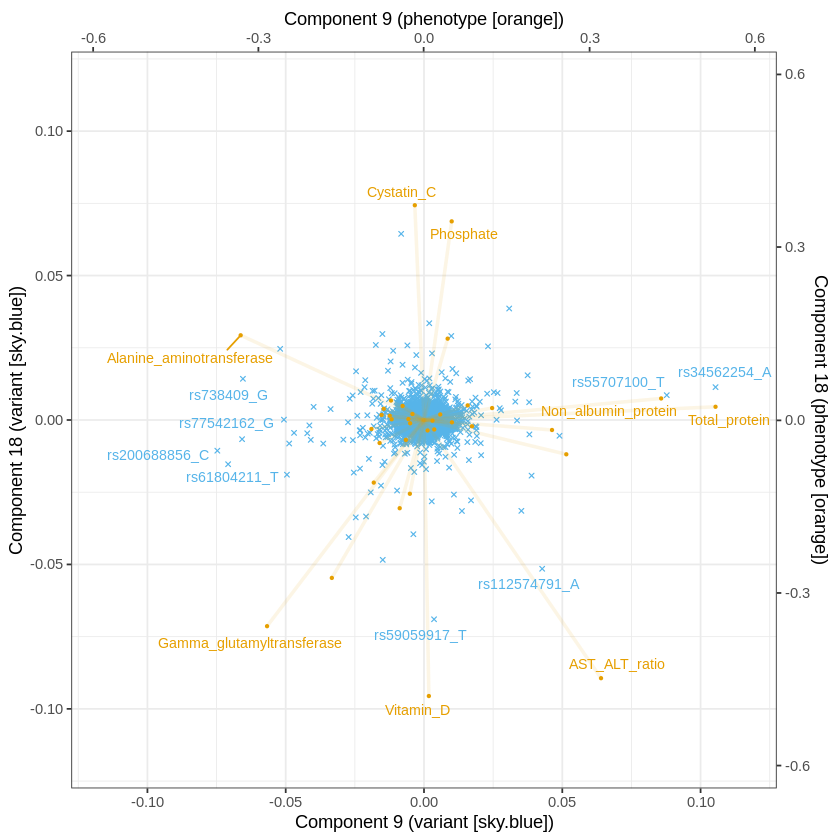

In [8]:
plot_biplot(
    svd_C, 
    component=list('x'=9, 'y'=18),
    label=list('phenotype'=colnames(fit$C), 'variant'=rownames(fit$C)),
    n_labels=list('phenotype'=8, 'variant'=8)
)

## Importance of the components (scree plot and trait squared cosine score)


In [43]:
((((svd_C$u) %*% diag(svd_C$d)) ** 2) / rowSums(((svd_C$u) %*% diag(svd_C$d)) ** 2)) %>%
as.data.frame() %>% rownames_to_column() %>%
gather(component, squared_cosine_score, -rowname) %>%
mutate(component = str_replace(component, '^V', 'Component')) %>%
bind_rows(
    ((svd_C$d ** 2) / sum(svd_C$d ** 2) ) %>%
    enframe(name = 'component', value='squared_cosine_score') %>%
    mutate(rowname = '(all traits combined)')
) %>%
mutate(rowname = str_replace(rowname, '_adjstatins', '')) %>%
mutate(rowname = str_replace(rowname, '_adjstatin', '')) %>%
mutate(rowname = str_replace_all(rowname, '_', ' ')) %>%
mutate(component_order=as.numeric(str_replace_all(component, '^Component', ''))) %>%
ggplot(aes(fill=reorder(component, component_order), y=squared_cosine_score, x=rowname)) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
coord_flip() + scale_y_reverse() +
theme(legend.position='bottom') +
labs(x = 'Phenotype', y = 'Relative importance of the components for each phenotype', fill='') -> p_squared_cosine


In [44]:
ggsave('squared_cosine.pdf', p_squared_cosine, width=16, height=16)


## Trait contribution score

In [41]:
(svd_C$u ** 2) %>% 
as.data.frame() %>% rownames_to_column() %>%
gather(component, contribution_score, -rowname) %>%
mutate(component = str_replace(component, '^Component', '')) %>%
mutate(component_order = as.integer(component)) %>%
mutate(rowname = str_replace(rowname, '_adjstatins', '')) %>%
mutate(rowname = str_replace(rowname, '_adjstatin', '')) %>%
mutate(rowname = str_replace_all(rowname, '_', ' ')) %>%
ggplot(aes(fill=rowname, y=contribution_score, x=reorder(component, component_order))) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
theme(legend.position='bottom') +
labs(
    x = 'Component',
    y = 'Phenotype contribution score',
    fill=''
) + guides(fill=guide_legend(ncol=3)) -> p_contribution


In [42]:
ggsave('contribution.pdf', p_contribution, width=16, height=16)


In [49]:
((((svd_C$u) %*% diag(svd_C$d)) ** 2) / rowSums(((svd_C$u) %*% diag(svd_C$d)) ** 2)) %>%
as.data.frame() %>% rownames_to_column() %>%
gather(component, squared_cosine_score, -rowname) %>%
filter(rowname == 'AST_ALT_ratio') %>%
arrange(-squared_cosine_score) %>%
head(5)


,rowname,component,squared_cosine_score
,<chr>,<chr>,<dbl>
1,AST_ALT_ratio,V9,0.20262831
2,AST_ALT_ratio,V18,0.16102610
3,AST_ALT_ratio,V20,0.15437741
4,AST_ALT_ratio,V8,0.13557293
5,AST_ALT_ratio,V3,0.09199192


In [53]:
(svd_C$u ** 2) %>% 
as.data.frame() %>% rownames_to_column() %>%
gather(component, contribution_score, -rowname) %>%
mutate(component = str_replace(component, '^Component', '')) %>%
filter(component %in% c(9, 18, 20, 8, 3)) %>%
left_join(
    data.frame(
        component = c('9', '18', '20', '8', '3'),
        component_order = 1:5,
        stringsAsFactors=F
    ),
    by='component'
) %>%
mutate(rowname = str_replace(rowname, '_adjstatins', '')) %>%
mutate(rowname = str_replace(rowname, '_adjstatin', '')) %>%
mutate(rowname = str_replace_all(rowname, '_', ' ')) %>%
ggplot(aes(fill=rowname, y=contribution_score, x=reorder(component, component_order))) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
theme(legend.position='bottom') +
labs(
    x = 'Component',
    y = 'Phenotype contribution score',
    fill=''
) + guides(fill=guide_legend(ncol=3)) -> p_contribution_AST_ALT_ratio


In [57]:
ggsave('contribution_AST_ALT_ratio.pdf', p_contribution_AST_ALT_ratio, width=10, height=10)


In [13]:
component_idx <- 1
top_k_variants <- 10

In [14]:
head(sort((svd_C$v[,component_idx]) ** 2, decreasing=TRUE), top_k_variants)

rs10455872_G rs73596816_A rs41272078_T rs11591147_T   rs445925_A  rs6919346_C 
 0.589843173  0.232685156  0.026642949  0.013453243  0.013246704  0.008670258 
rs12214416_A     rs7412_T rs80145669_A  rs3798220_C 
 0.008089141  0.007586170  0.006457878  0.005613598

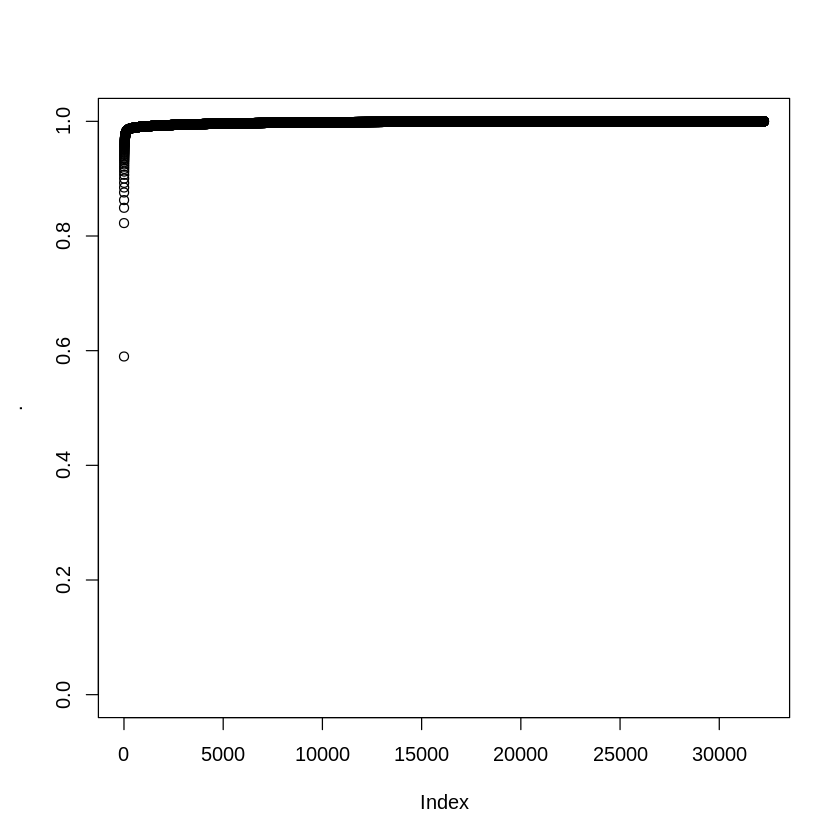

In [69]:
cumsum(sort((svd_C$v[,component_idx]) ** 2, decreasing=TRUE)) %>% plot(ylim = c(0, 1))

In [39]:
(svd_C$v ** 2) %>%
as.data.frame() %>% rownames_to_column() %>%
gather(component, contribution_score, -rowname) %>%
filter(contribution_score > .1)


rowname,component,contribution_score
<chr>,<chr>,<dbl>
rs10455872_G,Component1,0.5898432
rs73596816_A,Component1,0.2326852
rs11591147_T,Component2,0.1561662
rs117573122_C,Component3,0.3554947
rs887829_T,Component4,0.3643478
rs117573122_C,Component5,0.2473662
rs149344982_A,Component6,0.2156116
rs149344982_A,Component7,0.1164056
rs149344982_A,Component8,0.1116036


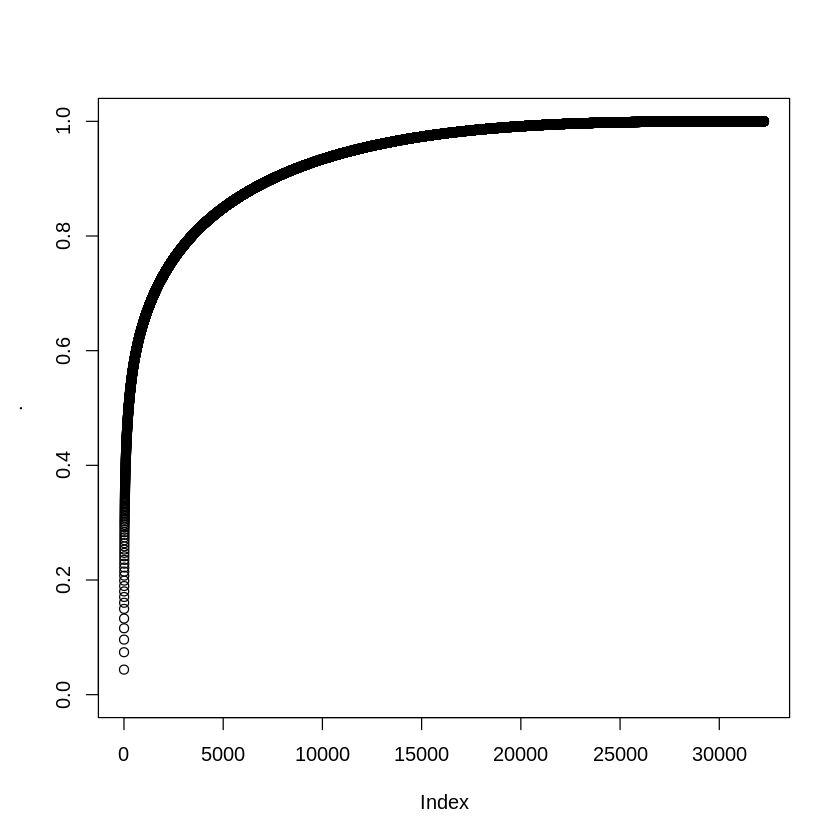

In [64]:
cumsum(sort((svd_C$v[,9]) ** 2, decreasing=TRUE)) %>% plot(ylim = c(0, 1))

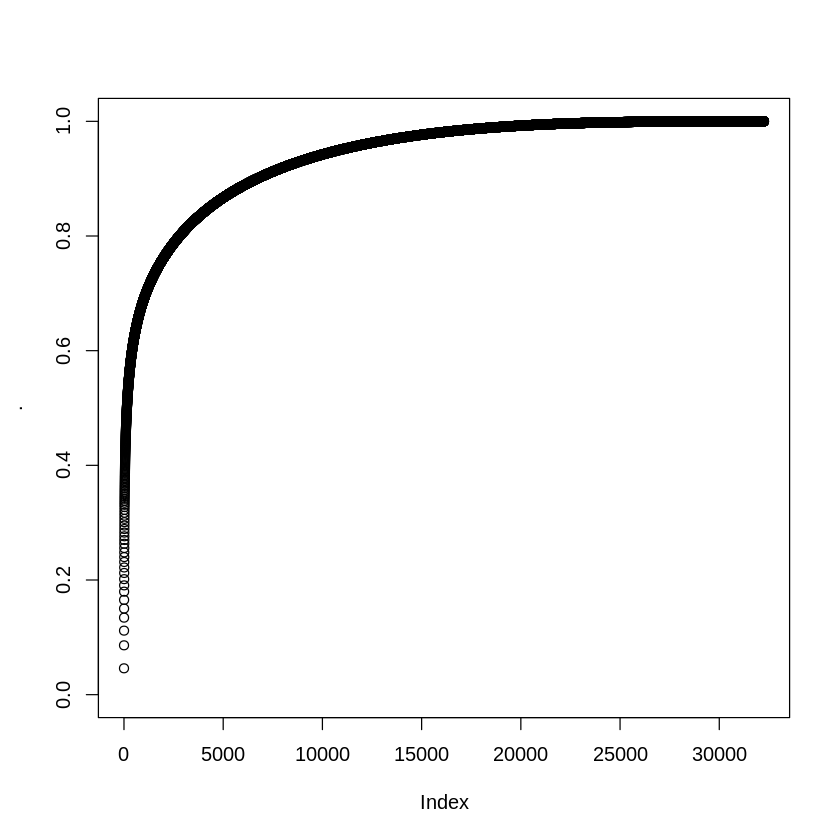

In [65]:
cumsum(sort((svd_C$v[,18]) ** 2, decreasing=TRUE)) %>% plot(ylim = c(0, 1))

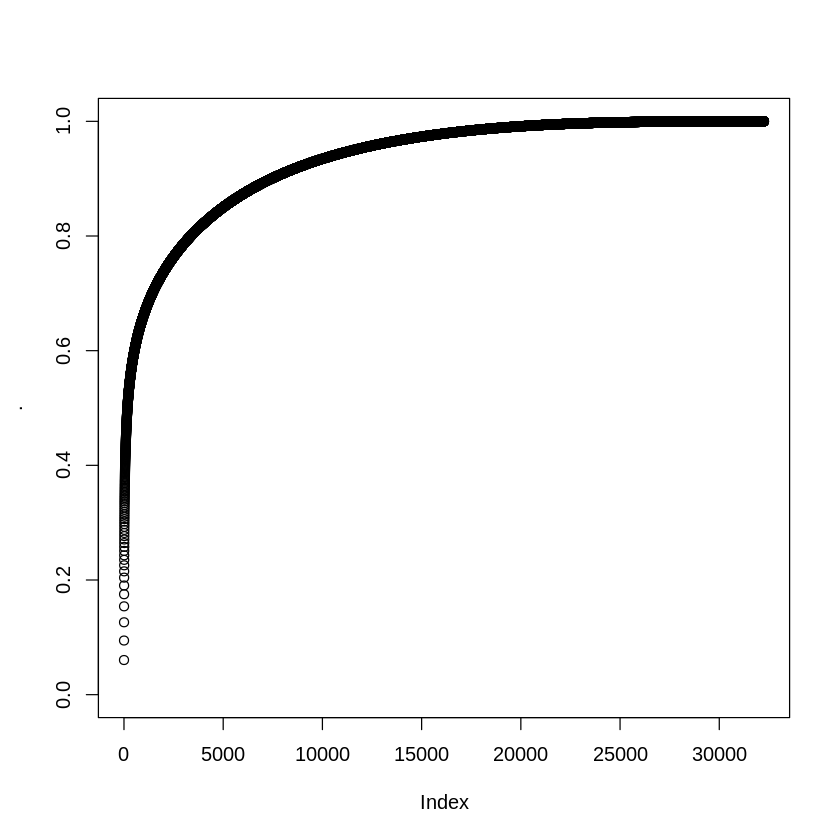

In [66]:
cumsum(sort((svd_C$v[,20]) ** 2, decreasing=TRUE)) %>% plot(ylim = c(0, 1))

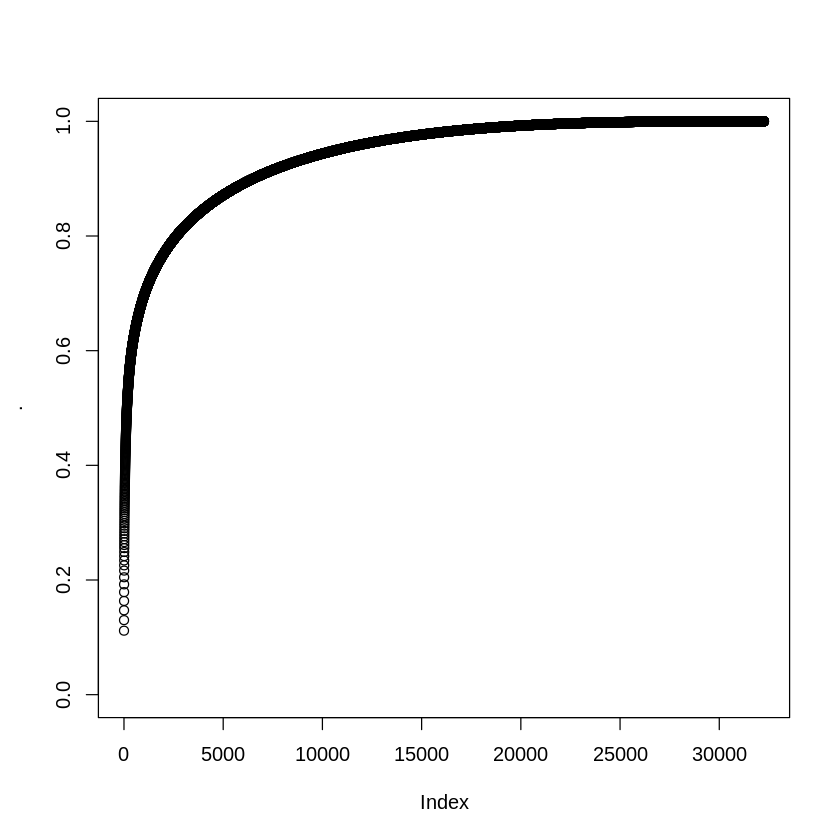

In [67]:
cumsum(sort((svd_C$v[,8]) ** 2, decreasing=TRUE)) %>% plot(ylim = c(0, 1))

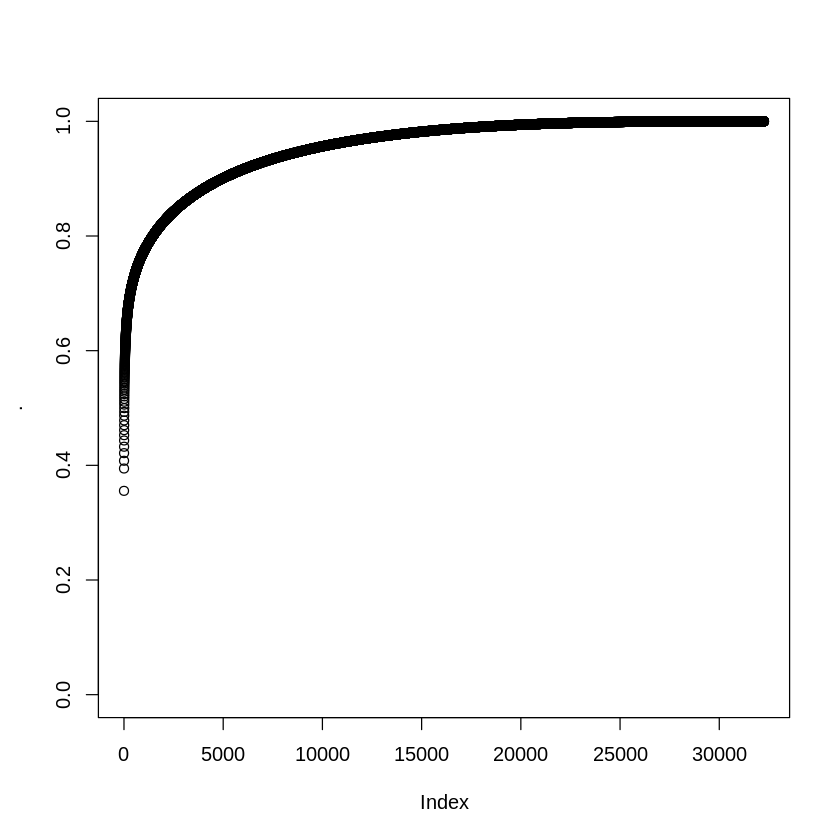

In [68]:
cumsum(sort((svd_C$v[,3]) ** 2, decreasing=TRUE)) %>% plot(ylim = c(0, 1))